# Base Model - using LSTM

- Train: 75Agree_train
- Test: 75Agree_test

In [9]:
import numpy as np
import random
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

### Step 1: Prepate the data to feed the model

In [10]:
# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_49783/918004758.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    336
1    336
2    336
Name: count, dtype: int64

### Step 2: Train the model with fine-tuned hyperparameters

In [11]:
# tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['sentence'])

X_train_seq = tokenizer.texts_to_sequences(df_train['sentence'])
X_test_seq = tokenizer.texts_to_sequences(df_test['sentence'])

# padding
lengths = df_train['sentence'].str.split().apply(len)
maxlen = int(np.percentile(lengths, 95))

X_train = pad_sequences(X_train_seq, maxlen=maxlen)
X_test = pad_sequences(X_test_seq, maxlen=maxlen)

# labels
y_train = df_train['label'].values
y_test = df_test['label'].values

In [12]:
def get_hyperparameters():
    return {
        "embedding_dim": random.choice([32, 64, 128, 256]),
        "lstm_units": random.choice([32, 64, 128, 256]),
        "epochs": random.choice([2, 3, 5, 8, 10, 15]),
        "lr": random.choice([1e-3, 5e-4, 1e-4, 1e-5]),
        "dropout": random.choice([0.2, 0.3, 0.5]),
        "recurrent_dropout": random.choice([0.0, 0.2, 0.3, 0.5])
    }

# cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    all_results = pd.read_csv("model LSTM.csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["embedding_dim", "lstm_units", "epochs", "lr", "dropout", "recurrent_dropout", "valloss"])


for _ in range(0):
    current_hyperparams = get_hyperparameters()
    current_results = {"embedding_dim": [], "lstm_units": [], "epochs": [], "lr": [], "dropout": [], "recurrent_dropout": [], "valloss": []}
    current_valloss = 0

    mask = (
        (all_results['embedding_dim'] == current_hyperparams['embedding_dim']) &
        (all_results['lstm_units'] == current_hyperparams['lstm_units']) &
        (all_results['epochs'] == current_hyperparams['epochs']) &
        (all_results['lr'] == current_hyperparams['lr']) &
        (all_results['dropout'] == current_hyperparams['dropout']) &
        (all_results['recurrent_dropout'] == current_hyperparams['recurrent_dropout'])
    )

    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparams}")

    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold + 1}", end=' | ')

        # split data
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # model definition
        model = Sequential([
            Embedding(input_dim=10000, output_dim=current_hyperparams['embedding_dim'], input_length=maxlen),
            LSTM(current_hyperparams['lstm_units'],
                 dropout=current_hyperparams['dropout'],
                 recurrent_dropout=current_hyperparams['recurrent_dropout']),
            Dense(3, activation='softmax')
        ])

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

        # train
        history = model.fit(X_train_fold, y_train_fold, epochs=current_hyperparams['epochs'], batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # evaluate
        val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Validation Loss: {val_loss}")

        current_valloss += val_loss

    current_valloss /= skf.n_splits
    current_results['embedding_dim'].append(current_hyperparams['embedding_dim'])
    current_results['lstm_units'].append(current_hyperparams['lstm_units'])
    current_results['epochs'].append(current_hyperparams['epochs'])
    current_results['lr'].append(current_hyperparams['lr'])
    current_results['dropout'].append(current_hyperparams['dropout'])
    current_results['recurrent_dropout'].append(current_hyperparams['recurrent_dropout'])
    current_results['valloss'].append(current_valloss)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)
    all_results.to_csv("model LSTM.csv", index=False)

"Hyperparameter tuning completed. Results saved to model LSTM.csv."

'Hyperparameter tuning completed. Results saved to model LSTM.csv.'

In [13]:
all_results = all_results.sort_values(by="valloss").reset_index(drop=True)
all_results.to_csv("model LSTM.csv", index=False)

print(f"Top 3 hyperparameter configurations based on validation loss from {all_results.shape[0]} trials:")

all_results.head(3)

Top 3 hyperparameter configurations based on validation loss from 82 trials:


,embedding_dim,lstm_units,epochs,lr,dropout,recurrent_dropout,valloss
0,256,64,5,0.0001,0.3,0.3,0.687673
1,32,32,15,0.0001,0.2,0.5,0.723233
2,64,32,8,0.0005,0.5,0.2,0.728909


In [14]:
best_hyperparams = all_results.iloc[0]

# convert the hyperparameters to the correct types
best_hyperparams = {
    "embedding_dim": int(best_hyperparams['embedding_dim']),
    "lstm_units": int(best_hyperparams['lstm_units']),
    "epochs": int(best_hyperparams['epochs']),
    "lr": float(best_hyperparams['lr']),
    "dropout": float(best_hyperparams['dropout']),
    "recurrent_dropout": float(best_hyperparams['recurrent_dropout'])
}

# final model with the best hyperparameters
model = Sequential([
    Embedding(input_dim=10000, output_dim=best_hyperparams['embedding_dim'], input_length=maxlen),
    LSTM(best_hyperparams['lstm_units'],
         dropout=best_hyperparams['dropout'],
         recurrent_dropout=best_hyperparams['recurrent_dropout']),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# train
history = model.fit(X_train, y_train, epochs=best_hyperparams['epochs'], batch_size=32, validation_data=(X_test, y_test), verbose=0)

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


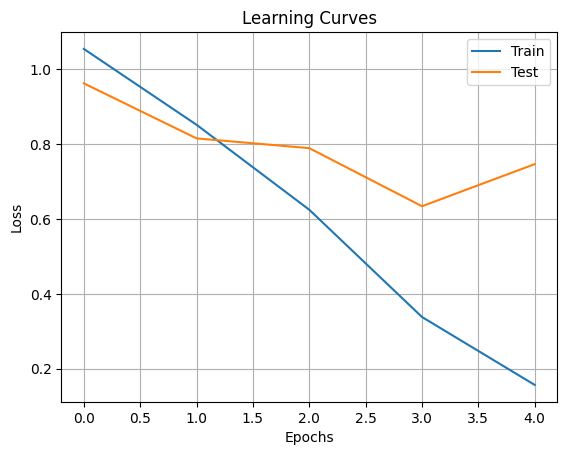

In [15]:
# learning curves
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Evaluate the model

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
=== Train ===
              precision    recall  f1-score   support

    negative      0.968     0.982     0.975       336
     neutral      0.997     0.994     0.996       336
    positive      0.979     0.967     0.973       336

    accuracy                          0.981      1008
   macro avg      0.981     0.981     0.981      1008
weighted avg      0.981     0.981     0.981      1008



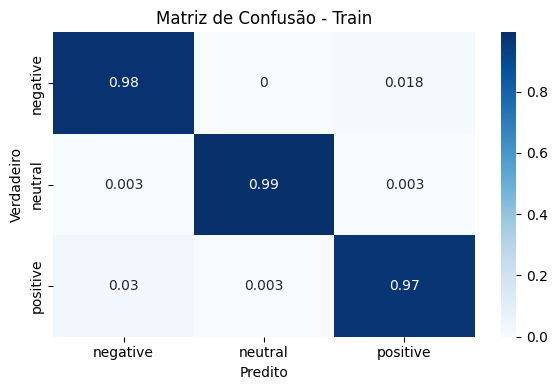

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
=== Test ===
              precision    recall  f1-score   support

    negative      0.562     0.750     0.643        84
     neutral      0.924     0.706     0.801       429
    positive      0.554     0.781     0.648       178

    accuracy                          0.731       691
   macro avg      0.680     0.746     0.697       691
weighted avg      0.785     0.731     0.742       691



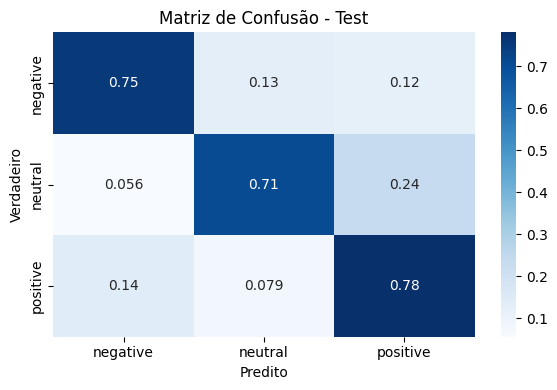

In [16]:
# Avaliação com seaborn
def print_metrics(X, y, title):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"=== {title} ===")
    print(classification_report(y, y_pred, target_names=[id2label[i] for i in range(3)], digits=3))

    cm = confusion_matrix(y, y_pred, normalize='true')
    labels = [id2label[i] for i in range(3)]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {title}')
    plt.tight_layout()
    plt.show()

print_metrics(X_train, y_train, "Train")
print_metrics(X_test, y_test, "Test")